In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt, seaborn as sns	

from sklearn.model_selection import train_test_split, GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,auc,average_precision_score,roc_curve,precision_recall_curve, precision_recall_fscore_support

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from sklearn.mixture import GaussianMixture


import warnings
warnings.filterwarnings("ignore")

<h3 style="color:orange">Hyperparameters</h3>

In [15]:
optimizer="lbfgs"
epoch=[100,1000,5000][1]
sample_ratio=[0.05,0.1,0.15,0.3][-1]


print(f"\u001b[33mOptimizer: \u001b[0m{optimizer}\n\u001b[33mEpochs: \u001b[0m{epoch}")
print(f"\u001b[33mSample Ratio: \u001b[0m{sample_ratio*100}%")

Optimizer: lbfgs
Epochs: 1000
Sample Ratio: 30.0%


<h3 style="color:orange">Load Data</h3>

In [16]:
data=pd.read_csv("./temp/creditcard.csv")
# data.duplicated().sum()
# data.isna().sum()

# for storing evaluation matrix of each model
model_scores={"Logistic Regression":dict(),"Gaussian Matrix Model":dict(),"GMM + CBU":dict()}


# standardize
st=StandardScaler()
data[["Time","Amount"]]=st.fit_transform(data[["Time","Amount"]])

# data
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000
mean,-3.065637e-16,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,2.913952e-17,0.001727
std,1.000002e+00,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,1.000002e+00,0.041527
min,-1.996583e+00,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,-3.532294e-01,0.000000
25%,-8.552120e-01,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,-3.308401e-01,0.000000
50%,-2.131453e-01,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,-2.652715e-01,0.000000
75%,9.372174e-01,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,-4.471707e-02,0.000000
max,1.642058e+00,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.023622e+02,1.000000


In [17]:
y=data["Class"]         # 0->valid, 1->fraud
x=data.drop(["Class"],axis=1)

y.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

<h3 style="color:orange">Visualize Class Distribution</h3>
from below Pie chart we can observer that the Dataset is imbalance. where around 99.83% of data is majority class. 

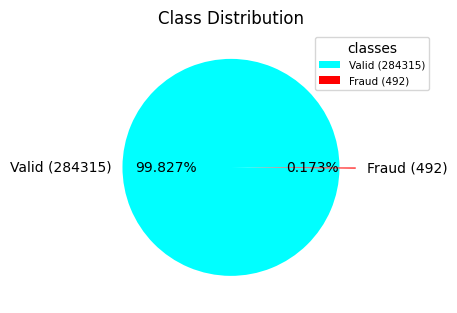

In [18]:
plt.figure(figsize=(3.5, 5))
plt.pie(y.value_counts().values,labels=[f"Valid ({y.value_counts()[0]})",f"Fraud ({y.value_counts()[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

<h3 style="color:orange">Split Data</h3>

In [19]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=8)

print(f"x train: {x_train.shape}, y train: {y_train.shape}\nx test: {x_test.shape}, y test: {y_test.shape}")

x train: (199364, 30), y train: (199364,)
x test: (85443, 30), y test: (85443,)


In [20]:
print(y_train.value_counts())   
print(y_test.value_counts())

Class
0    199030
1       334
Name: count, dtype: int64
Class
0    85285
1      158
Name: count, dtype: int64


<h3 style="color:orange">Model 1 (Logistic Regression)</h3>

Here we can observe below that the accuracy is misleading because of the imbalanced dataset. The model has achieved very high accuracy just by predicting the majority class, while completely failing to detect the minority (fraudulent) class.

In the evaluation metrics, we can see that the **Precision, Recall**, and the **F1-score** for valid transactions are nearly ~100%. However, for fraudulent transactions, precision and F1-score are very low, while recall is somewhat stable but still not good enough to use on real data. Having low precision means the model is incorrectly identifying some valid transactions as fraudulent, which could create issues for legitimate data points.

 Logistic Regression Accuracy: 0.977095841672226
 Accuracy on orignal vs predicted values: 0.977095841672226
 Confusion Matrix:
 [[83344  1941]
 [   16   142]]
 report: 
Valid: {'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
Fraud: {'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
accuracy: 0.977095841672226
macro avg: {'precision': 0.5339894843827604, 'recall': 0.9379875963170398, 'f1-score': 0.557562440656714, 'support': 85443.0}
weighted avg: {'precision': 0.9980852910313859, 'recall': 0.977095841672226, 'f1-score': 0.9868023607096873, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


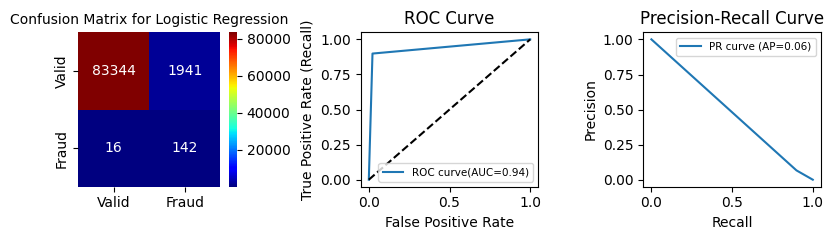

In [21]:
model1=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on imbalance data
model1.fit(x_train,y_train)

# predection on x_test
y_pred=model1.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model1.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["Logistic Regression"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

<h3 style="color:orange">Gaussian Mixture Models (GMM)-Based Synthetic Sampling</h3>
in this techninque we use probability model of the minority distribution....

<h5 style="color:cyan">Steps in GMM-Based Synthetic Sampling</h5>

- Fit GMM on the minority class data
    - The minority class data is assumed to follow a mixture of multiple Gaussian distributions.
- Sample from the GMM
    - Once fitted, we can generate new synthetic minority samples by drawing from the learned distribution.
    - sampling from Fitted GMM is a 2 step stochastic process
        - draw component index 'k' from the categorical distribution defined by the mixture weights:
        <br>$$k\sim Categorical(\pi_1,...,\pi_k)$$
        - draw a sample from choosen Gaussian:
        <br>$$ x_{new} \sim \mathcal{N}(\mu_k, \Sigma_k) $$
        - so the constructive formula for the draw from $\mathcal{N}(\mu_k, \Sigma_k)$ is
        <br> $$x_{new}=\mu_k +L_kz,\;\;z\sim\mathcal{N}(0,I_d)$$

    where $L_k$ is a matrix square root of $\Sigma_k$

        
- Add synthetic samples to the dataset
    - The generated data points are added to balance the dataset. these are similar to SMOTE but more probabilistic.


<h5 style="color:cyan">trade off between SMOTE and GMM</h5>

- SMOTE generates synthetic points by linear interpolation between neighbors. This may produce unrealistic samples in sparse regions.
    - it use K-nearest neighbours $x_{nn}$ to interpolate between.
    $$x_{new}=x_i+\lambda(x_{nn}-x_i)$$
- GMM learns the probabilistic structure of the minority class and generates more realistic synthetic samples that capture multi-modality.
    - here model assume the minority data is mixture of K gaussians with paramter $\{\pi_k,\mu_k,\sum_k\}_{k=1}^K$ where $\pi_k$ is mixing weights, $\mu_k$ is mean and $\sum_k$ is covariance matrices.
    $$x_{new}=\mu_k +L_kz,\;\;z\sim\mathcal{N}(0,I_d),\;\;L_k\text{ is a matrix square root of }\Sigma_k$$

- this Helps when minority data has clusters or complex distributions.


<h5 style="color:cyan">trade off between SMOTE and GMM</h5>

|Pros|Cons|
|:-:|:-:|
|Captures multi-modal distributions (works well when minority class has multiple clusters)|Computationally expensive for large high-dimensional datasets|
|Generates more natural samples compared to interpolation methods | Sensitive to the choice of number of mixture components|
|Flexible — number of components can be tuned | If minority data is very sparse, GMM may overfit or fail to capture the distribution|


<h5 style="color:cyan">estimating optimal k for GMM</h5>

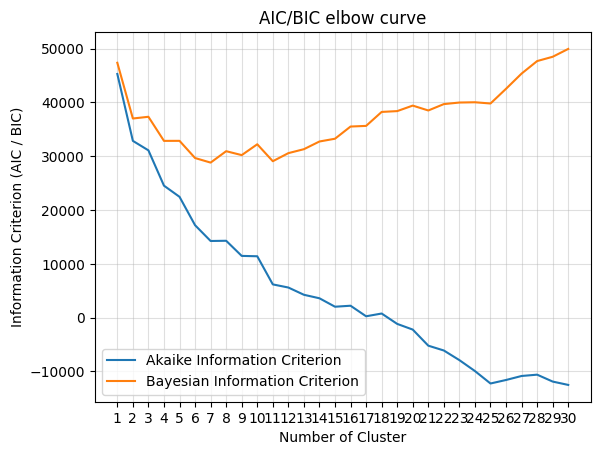

In [ ]:
x_major=data[data["Class"]==0].drop(["Class"],axis=1)
x_minor=data[data["Class"]==1].drop(["Class"],axis=1)

aic_score,bic_score=[],[]

for k in range(1,x_minor.shape[1]+1):
    gmm=GaussianMixture(n_components=k,random_state=8).fit(x_minor)
    aic_score.append(gmm.aic(x_minor))
    bic_score.append(gmm.bic(x_minor))

# print(aic_score) 
# print(bic_score)

plt.plot(aic_score,label="Akaike Information Criterion")
plt.plot(bic_score,label="Bayesian Information Criterion")
plt.xlabel("Number of Cluster")
plt.xticks([i for i in range(x_minor.shape[1])],[i+1 for i in range(x_minor.shape[1])])
plt.ylabel("Information Criterion (AIC / BIC)")
plt.title("AIC/BIC elbow curve")

plt.legend()
plt.grid(True,alpha=0.4)

<h5 style="color:cyan">genrating sample based on k components</h5>

after getting the optimtimal n_components we create the synthetic samples of minority class 

In [23]:
# based on above the optimal n_componets=4
N=4

x_minor=data[data["Class"]==1].drop(["Class"],axis=1)
y_minor=data[data["Class"]==1]["Class"]
print(f"x minor shape: {x_minor.shape}\ty minor shape: {y_minor.shape}")

x_major=data[data["Class"]==0].drop(["Class"],axis=1)
y_major=data[data["Class"]==0]["Class"]
print(f"x major shape: {y_major.shape}\ty major shape: {y_major.shape}")



x minor shape: (492, 30)	y minor shape: (492,)
x major shape: (284315,)	y major shape: (284315,)


In [24]:
gmm=GaussianMixture(n_components=N,covariance_type='full', random_state=8)
gmm.fit(x_minor)

x_synthetic,y_synthetic=gmm.sample(n_samples=int(data.shape[0]*sample_ratio))

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([np.zeros(len(x_major)),np.ones(len(x_minor)+len(x_synthetic))])

print(x_synthetic.shape)

x_balanced=np.vstack([x_major,x_minor,x_synthetic])
y_balanced=np.hstack([y_major,y_minor,np.ones(y_synthetic.shape[0])])

print(x_balanced.shape)
print(np.bincount(y_balanced.astype(np.int64)))

(85442, 30)
(370249, 30)
[284315  85934]


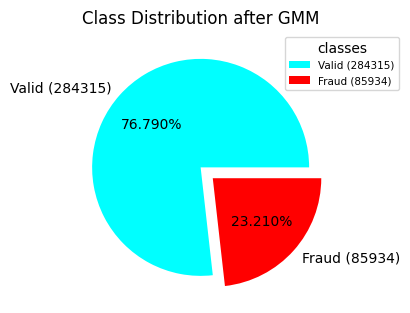

In [25]:
plt.figure(figsize=(3.5, 5))
plt.pie(np.bincount(y_balanced.astype(np.int64)),labels=[f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution after GMM")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

<h5 style="color:cyan">Inference on Logistic Regression</h5>

 Logistic Regression Accuracy: 0.9831583628851983
 Accuracy on orignal vs predicted values: 0.9831583628851983
 Confusion Matrix:
 [[83859  1426]
 [   13   145]]
 report: 
Valid: {'precision': 0.9998450019076688, 'recall': 0.9832795919563816, 'f1-score': 0.9914931099511105, 'support': 85285.0}
Fraud: {'precision': 0.09229789942711648, 'recall': 0.9177215189873418, 'f1-score': 0.16772700983227298, 'support': 158.0}
accuracy: 0.9831583628851983
macro avg: {'precision': 0.5460714506673926, 'recall': 0.9505005554718617, 'f1-score': 0.5796100598916918, 'support': 85443.0}
weighted avg: {'precision': 0.9981667785050269, 'recall': 0.9831583628851983, 'f1-score': 0.9899698132056922, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


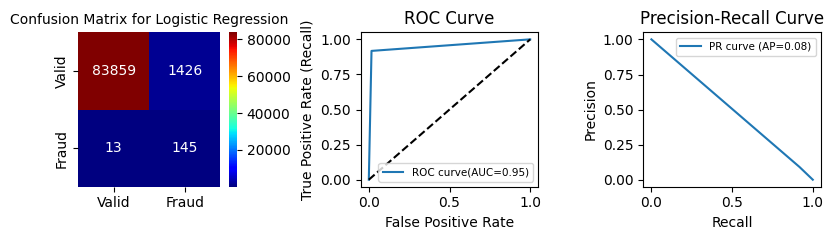

In [26]:
model2=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on balance data
model2.fit(x_balanced,y_balanced)

# predection on x_test
y_pred=model2.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model2.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["Gaussian Matrix Model"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

<h3 style="color:orange">GMM + CBU</h3>

The issue with using only GMM-based oversampling is that it can generate too many synthetic samples, which not only increases training time but may also lead to noise and overfitting.

To Overcome this, we first apply Gaussian Mixture Model (GMM) based oversampling to the minority class in order to generate synthetic fraud samples and strengthen its representation. then we subsequently apply Clustering-Based Undersampling (CBU) on the majority class to reduces redundant normal samples while maintaining diversity, ensuring that the ratio between majority and minority classes is balanced. 

By combining GMM oversampling with CBU, we obtain a more compact and representative dataset that reduces computation cost while improving the learning capability of the classifier.

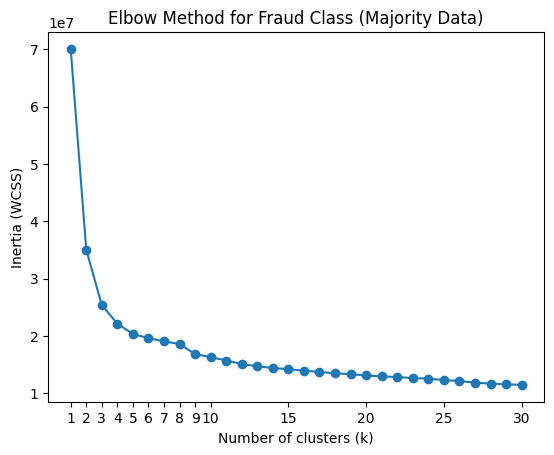

In [27]:
# check value of K for K-CLusters
inertia=[]

for k in range(1,x_balanced.shape[1]+1):
    kmeans=KMeans(n_clusters=k,random_state=8)
    kmeans.fit(x_balanced)
    inertia.append(kmeans.inertia_)

# print(inertia)

plt.plot(inertia,marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Fraud Class (Majority Data)")
_=plt.xticks([0,1,2,3,4,5,6,7,8,9,14,19,24,29],labels=[1,2,3,4,5,6,7,8,9,10,15,20,25,30])

In [28]:
K=3     # based on above plot

kmeans=KMeans(n_clusters=K,random_state=8)
clusters=kmeans.fit_predict(x_major)

# print(clusters)

# add clustors to dataframe
xdf_major=pd.DataFrame(x_major)
xdf_major["cluster"]=clusters

xdf_major["cluster"].value_counts()

cluster
2    145790
0    132766
1      5759
Name: count, dtype: int64

In [29]:
# synetic data from GMM combined with x_minor
x_minor_new=np.vstack([x_minor,x_synthetic])        
y_minor_new=np.hstack([y_minor,np.ones(len(y_synthetic))])

print(y_minor_new.shape)

(85934,)


In [30]:
x_major_balanced=[]
y_major_balanced=[]

target_size=x_minor_new.shape[0]
print(target_size) 

for c in range(K):
    cluster_data=xdf_major[xdf_major["cluster"]==c].drop(["cluster"],axis=1).values
    
    if len(cluster_data)>target_size:
        cluster_balanced=resample(
            cluster_data,
            replace=False,
            n_samples=target_size,
            random_state=8
        )
    else:
        cluster_balanced=cluster_data

    x_major_balanced.append(cluster_balanced)
    y_major_balanced.append(np.zeros(len(cluster_balanced)))

# concat undersampled clusters
x_major_final=np.vstack(x_major_balanced)
y_major_final=np.hstack(y_major_balanced)

x_balanced=np.vstack([x_minor_new,x_major_final])
y_balanced=np.hstack([y_minor_new,y_major_final])


print(x_balanced.shape)
print(y_balanced.shape)
print("After CBU undersampling:", np.bincount(y_balanced.astype(int)))

85934
(263561, 30)
(263561,)
After CBU undersampling: [177627  85934]


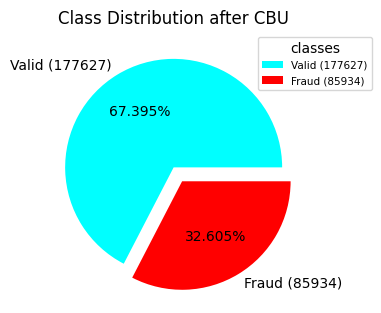

In [31]:
plt.figure(figsize=(3.5, 5))
plt.pie(np.bincount(y_balanced.astype(np.int64)),labels=[f"Valid ({np.bincount(y_balanced.astype(np.int64))[0]})",f"Fraud ({np.bincount(y_balanced.astype(np.int64))[1]})"],autopct='%2.3f%%',explode=[0,0.15],colors=["cyan","red"])

plt.title("Class Distribution after CBU")
plt.legend(title="classes",loc=1,bbox_to_anchor=(1.25,1),fontsize=7.5)

 Logistic Regression Accuracy: 0.9849490303477172
 Accuracy on orignal vs predicted values: 0.9849490303477172
 Confusion Matrix:
 [[84012  1273]
 [   13   145]]
 report: 
Valid: {'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
Fraud: {'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}
accuracy: 0.9849490303477172
macro avg: {'precision': 0.5510509918592467, 'recall': 0.9513975479089842, 'f1-score': 0.588207308733237, 'support': 85443.0}
weighted avg: {'precision': 0.9981854758909635, 'recall': 0.9849490303477172, 'f1-score': 0.9909095937306241, 'support': 85443.0}
----------------------------------------------------------------------------------------------------------------------------------


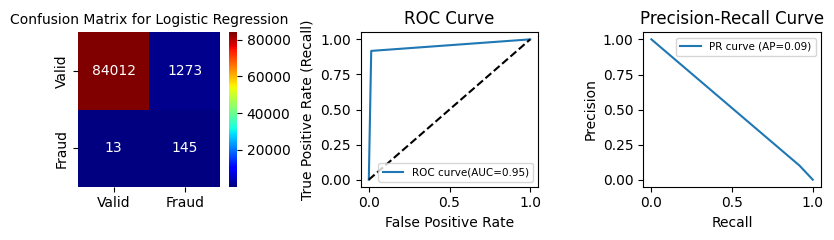

In [32]:
model3=LogisticRegression(solver=optimizer,max_iter=epoch,class_weight="balanced")

# train on balance data
model3.fit(x_balanced,y_balanced)

# predection on x_test
y_pred=model3.predict(x_test)

# model1 evaluation score
print(f"\u001b[33m Logistic Regression Accuracy: \u001b[0m{model3.score(x_test,y_test)}")
print(f"\u001b[33m Accuracy on orignal vs predicted values: \u001b[0m{accuracy_score(y_test,y_pred)}")
print(f"\u001b[33m Confusion Matrix:\n \u001b[0m{confusion_matrix(y_test,y_pred)}")
print("\u001b[33m report: \u001b[0m")
for k,v in classification_report(y_test,y_pred,output_dict=True,target_names=["\u001b[32mValid\u001b[0m", "\u001b[32mFraud\u001b[0m"]).items():
    print(f"{k}: {v}")

    if k in["\u001b[32mValid\u001b[0m","\u001b[32mFraud\u001b[0m"]:
        model_scores["GMM + CBU"][k[5:-4]]=v
print(f"{'-':-^130}")

plt.figure(figsize=(8,2.5))
plt.subplots_adjust(wspace=0.4)

plt.subplot(1,3,1)
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cmap="jet",label=["Valid","Fraud"],xticklabels=["Valid", "Fraud"], yticklabels=["Valid", "Fraud"])
plt.title("Confusion Matrix for Logistic Regression",fontdict={"fontsize":10})

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f"ROC curve(AUC={roc_auc:.2f})")
plt.plot([0,1], [0,1], 'k--')  # diagonal line (random model)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend(fontsize=7.5)

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
avg_pr = average_precision_score(y_test, y_pred)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f"PR curve (AP={avg_pr:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(fontsize=7.5)

plt.tight_layout()

<h3 style="color:orange">Performance Evaluation</h3>

After experimenting, we observe that all models perform almost perfectly on the majority  "Valid" class due to its dominance in the dataset. However, significant differences appear for the "Fraud" class. 

Here we can observe that precision and F1-score have improved to some extent, with a  significant increase after using GMM and GMM+CBU. This improvement occurs because GMM generates more representative synthetic samples for the fraud class, and with the addition  of CBU, the balance between minority and majority samples is maintained by removing redundant majority points. As a result, the classifier is able to learn a clearer decision boundary, leading to better detection performance for fraudulent transactions.

In [33]:
for name,param in model_scores.items():
    print(name)
    for k,v in param.items():
        print(f"\t{k}:{v}")

Logistic Regression
	Valid:{'precision': 0.9998080614203455, 'recall': 0.9772410154188896, 'f1-score': 0.9883957425360965, 'support': 85285.0}
	Fraud:{'precision': 0.06817090734517522, 'recall': 0.8987341772151899, 'f1-score': 0.12672913877733155, 'support': 158.0}
Gaussian Matrix Model
	Valid:{'precision': 0.9998450019076688, 'recall': 0.9832795919563816, 'f1-score': 0.9914931099511105, 'support': 85285.0}
	Fraud:{'precision': 0.09229789942711648, 'recall': 0.9177215189873418, 'f1-score': 0.16772700983227298, 'support': 158.0}
GMM + CBU
	Valid:{'precision': 0.9998452841416245, 'recall': 0.9850735768306267, 'f1-score': 0.9924044651822101, 'support': 85285.0}
	Fraud:{'precision': 0.10225669957686882, 'recall': 0.9177215189873418, 'f1-score': 0.18401015228426396, 'support': 158.0}


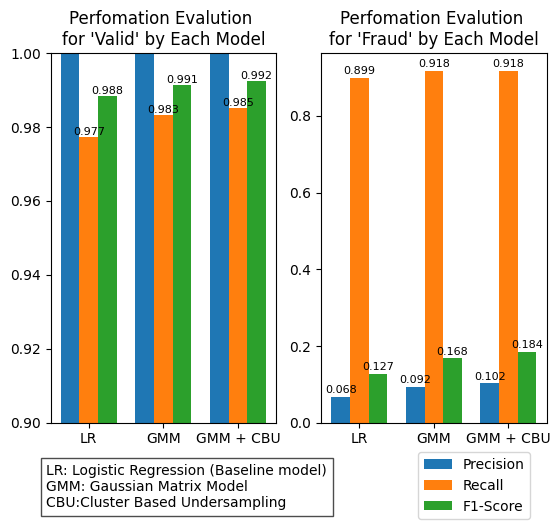

In [34]:
valid=[]
fraud=[]
for name,metric in model_scores.items():
    for k,v in metric.items():
        valid.append(v) if k=="Valid" else fraud.append(v)

vp=[d["precision"] for d in valid]
vr=[d["recall"] for d in valid]
vf1=[d["f1-score"] for d in valid]

fp=[d["precision"] for d in fraud]
fr=[d["recall"] for d in fraud]
ff1=[d["f1-score"] for d in fraud]


fig,ax=plt.subplots(1,2)
ax[0].bar([i-0.25 for i in range(len(model_scores))],vp,0.25,label="Precision")
ax[0].bar([i for i in range(len(model_scores))],vr,0.25,label="Recall")
ax[0].bar([i+0.25 for i in range(len(model_scores))],vf1,0.25,label="F1-Score")

ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[0].set_ylim(bottom=0.9,top=1.0)
ax[0].set_title("Perfomation Evalution \nfor 'Valid' by Each Model")
ax[0].legend(loc="center left", bbox_to_anchor=(1.6, -0.17))

# # add text on bar
for i,x in enumerate(vr):
    ax[0].text(i,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(vf1):
    ax[0].text(i+0.25,x+0.0005,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

# 2nd axis
ax[1].bar([i-0.25 for i in range(len(model_scores))],fp,0.25,label="Precision")
ax[1].bar([i for i in range(len(model_scores))],fr,0.25,label="Recall")
ax[1].bar([i+0.25 for i in range(len(model_scores))],ff1,0.25,label="f1-Score")

# add text on bar
for i,x in enumerate(fp):
    ax[1].text(i-0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(fr):
    ax[1].text(i,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})
for i,x in enumerate(ff1):
    ax[1].text(i+0.25,x+0.01,f"{x:.3f}",ha="center",fontdict={"fontsize":8})

ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels(["LR","GMM","GMM + CBU"],rotation=0)

ax[1].set_title("Perfomation Evalution \nfor 'Fraud' by Each Model")

plt.text(-4.2, -0.22, "LR: Logistic Regression (Baseline model)\nGMM: Gaussian Matrix Model \nCBU:Cluster Based Undersampling", fontsize=10,
         bbox=dict(facecolor="white", alpha=0.7))


if "assests" not in os.listdir("./"):
    os.makedirs("assests")
plt.savefig(f"./assests/model comparision ({optimizer}_{epoch}_{sample_ratio}).png",bbox_inches="tight")